In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# Project Write a Data Science Blog Post


# Part 1: Business understanding
## Brief description
This project is part of the Udacity course for Data Scientist.
The corresponding blog can be found on medium:
https://medium.com/@nicolas.guebel/whats-driving-the-price-of-a-night-s-stay-1eb786cb664c.

The project analyses AirBnB data for two cities of Seatle and Boston.
We investigate in this Notebook questions related to accommodation pricing:
- ### Question 1: Does pricing fluctuate over time? Can any patterns can be found?
- ### Question 2: Does occupancy of accomodations fluctuate over time? Can any patterns can be found?
- ### Question 3: Are there any features that correlates with pricing of accommodation?

# Part 2: Data understanding / getting to know the data

The provided data is divided in **3 datasets** for each cites consisting of:
- **calendar**: showing for each day, if an accomodation (listing_id) has been booked or not and if so to what price.
- **reviews**: the text of each reviews for a particular stay. Unfortunately the actual review score is not included and was not used to answer our questions.
- **listings**: this dataset gives us various information about each accommodation (size, number of guests, location, booking policy, etc.), host (name, picture, response time) and aggregated review scores.

## 2.1. Loading the data

In [120]:
# setting path for seatle data
seatle_data_path = "./seatle-data/"

# Loadind data
seatle_calendar = pd.read_csv(seatle_data_path + 'calendar.csv')
seatle_reviews = pd.read_csv(seatle_data_path + 'reviews.csv')
seatle_listings = pd.read_csv(seatle_data_path + 'listings.csv')

In [121]:
# setting path for seatle data
boston_data_path = "./boston-data/"

# reading data
boston_calendar = pd.read_csv(boston_data_path + 'calendar.csv')
boston_reviews = pd.read_csv(boston_data_path + 'reviews.csv')
boston_listings = pd.read_csv(boston_data_path + 'listings.csv')

## 2.2. Dataset 1: Calendar dataset

We will take a look at a random sample of 10 of both dataset and the datatype of each columns. We then identifies, if and what type of cleaning would be necessary. We also want to make sure, that cleaning steps can be performed on both dataset in the same way. This will allow us to use common function for cleaning.  

In [122]:
# Taking a sample of 10
seatle_calendar.sample(10)

,listing_id,date,available,price
1063726,9546633,2016-04-29,t,$89.00
496667,7347229,2016-09-27,f,NaN
1299622,3811955,2016-08-13,t,$30.00
1288694,3811930,2016-09-04,t,$30.00
156963,9596,2016-01-17,t,$120.00
482952,8815061,2016-03-01,t,$169.00
891679,4181226,2016-12-18,t,$109.00
845852,2686659,2016-05-30,t,$95.00
668688,7071331,2016-01-12,t,$42.00
1070905,82763,2016-12-29,t,$100.00


In [123]:
seatle_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [124]:
boston_calendar.sample(10)

,listing_id,date,available,price
364488,9841645,2017-01-30,f,NaN
1305365,5280827,2017-04-29,t,$75.00
507089,10266397,2017-02-25,f,NaN
247015,2043529,2017-06-11,t,$195.00
710077,6742905,2017-02-08,t,$99.00
782426,4303606,2017-08-07,t,$189.00
1130172,8366402,2017-04-11,f,NaN
1279742,14650655,2017-05-19,t,$127.00
238930,13007124,2016-12-31,t,$148.00
228058,10117329,2017-04-30,f,NaN


We notice that Price is set to NaN, when the "available" column is set to "f". We want to make sure, that is it always the case, guessing "t" stands for "taken" and "f" for "free".
Looking at the possible values of the "available" column, only takes values "t" and "f, confirming our guess.

In [125]:
# Making sure there are only 2 values possible "t" and "f"
seatle_calendar.available.value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [126]:
# Looking if price is set, when available is set to "free"
seatle_calendar[seatle_calendar.available == 'f']['price'].value_counts()

Series([], Name: price, dtype: int64)

**Observations for data wrangling of Calendar**
* **date** is a type object -> This should be change to date.
* **price** has the currency \\$ -> We should remove the $ sign and change its type to float
* **price** has comma delimiter for thousands -> comma needs removal
* **price** is set to Null, when not booked (availability f = "free" vs. t = "taken"). This is not an error. Nulls can be ignored wenn calculating means, min, max values. 

## 2.3: Dataset 2: Reviews dataset

In [127]:
# Reviewing data
seatle_reviews.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
5,7202016,43979139,2015-08-23,1154501,Barent,"Kelly was great, place was great, just what I ..."
6,7202016,45265631,2015-09-01,37853266,Kevin,Kelly was great! Very nice and the neighborhoo...
7,7202016,46749120,2015-09-13,24445447,Rick,hola all bnb erz - Just left Seattle where I h...
8,7202016,47783346,2015-09-21,249583,Todd,Kelly's place is conveniently located on a qui...
9,7202016,48388999,2015-09-26,38110731,Tatiana,"The place was really nice, clean, and the most..."


In [128]:
# Look at the datatype
seatle_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


**Observations from data exploration**
* **date** is a type object -> should be changed to date.
* Unfortunately there are no review rating in this dataset, only comments, making a link to a given price paid not possible. 
* This dataset is not helpfull in answering our business questions of Part 1. **Therefore this dataset won't be used.**

## 2.4. Dataset 3: Listing dataset

### Observations from data exploration
* Dataset with the most information
* Lists details / summary on locations
* review_scores_rating is in percent, rest of scores are from a rating from 1 - 10
* all review scores review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin,  review_scores_communication, review_scores_location and review_scores_value have a 25% percentile of 9 or 10.


In [129]:
# Taking a sample of the data
seatle_listings.sample(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2034,421168,https://www.airbnb.com/rooms/421168,20160104002432,2016-01-04,Greenwood Studio,Our backyard studio is ready to welcome guests...,We have a cute private studio (with bathroom) ...,Our backyard studio is ready to welcome guests...,none,We've lived in Seattle for almost a decade and...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,4.91
3733,4349344,https://www.airbnb.com/rooms/4349344,20160104002432,2016-01-04,Sweet Retreat,Light Airy Clean In the heart of the center of...,"When neighbors drop by, they usually comment o...","When neighbors drop by, they usually comment o...",none,"If you stay for more than a couple of days, yo...",...,9.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.61
3486,3303376,https://www.airbnb.com/rooms/3303376,20160104002432,2016-01-04,Zen space/yoga room warm and modern,Although the rest of our building is vintage c...,This new room is done in a fresh relaxing mode...,Although the rest of our building is vintage c...,none,Georgetown is easy access to mass transit (bus...,...,9.0,f,NaN,WASHINGTON,f,moderate,t,t,5,1.08
3237,9887142,https://www.airbnb.com/rooms/9887142,20160104002432,2016-01-04,"Why share, have it all to yourself.","Private entry, room & bath, not a shared livin...","Ours is a split level home with us, the owners...","Private entry, room & bath, not a shared livin...",none,Wedgwood is in northeast Seattle and sometimes...,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
1155,6990477,https://www.airbnb.com/rooms/6990477,20160104002432,2016-01-04,Westlake Ave Downtown Condos 1BD 2,98 Walkscore unit on a high floor right downto...,Other units in the same building: https://www...,98 Walkscore unit on a high floor right downto...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,strict,t,t,3,4.24


In [130]:
# Listing all columns and type
seatle_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

We notice that review_scores are ranging from 1 to 10, except for the review_scores_rating which ranges from 0 to 100%. We will investigate the distribution of this column to make sure the values seems plausible.

In [131]:
# Looking at statistics for numerical values
seatle_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


The experience column has no valuable information

In [132]:
# The "experiences" column has no information
seatle_listings.experiences_offered.value_counts()

none    3818
Name: experiences_offered, dtype: int64

Should we want to use the calendar_updated column, it would need to be converted into a number of days for example using a dictionary.

In [133]:
# calendar_updated is a categorical column
seatle_listings.calendar_updated.value_counts()

today            706
2 weeks ago      347
3 weeks ago      300
2 months ago     281
a week ago       248
yesterday        231
3 months ago     218
4 weeks ago      213
3 days ago       162
5 weeks ago      156
4 days ago       145
4 months ago     133
5 days ago       132
6 weeks ago      118
2 days ago        96
5 months ago      91
7 weeks ago       63
6 months ago      29
6 days ago        28
1 week ago        26
never             24
7 months ago      23
8 months ago      14
10 months ago      8
9 months ago       7
11 months ago      5
12 months ago      5
22 months ago      2
13 months ago      2
30 months ago      1
14 months ago      1
16 months ago      1
15 months ago      1
17 months ago      1
Name: calendar_updated, dtype: int64

The price column has the same formatting issues than the "calendar" dataset. We will use the same function for cleaning

In [134]:
# Looking at the price column
seatle_listings.price

0        $85.00
1       $150.00
2       $975.00
3       $100.00
4       $450.00
         ...   
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 3818, dtype: object

Further, we look at the distribution of the review_scores_rating column from both cities. These seem plausible and noticing that barely an accomodation has a score below 80% and most above 90%

<AxesSubplot:>

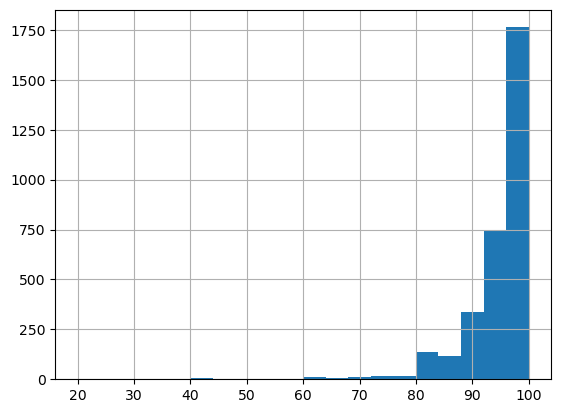

In [135]:
# Distribution for Seatle
seatle_listings.review_scores_rating.hist(bins=20)

<AxesSubplot:>

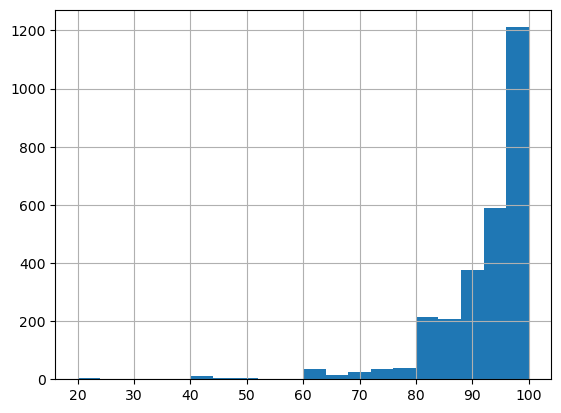

In [136]:
# Distribution for Boston
boston_listings.review_scores_rating.hist(bins=20)

# Part 3: Data Cleaning 

## 3.1 Cleaning Calendar Dataset

Based on the observations from Part 2.2 we will adress both issues:
- **price**: remove comma delimiter for thousands and remove currency $ sign
- **date**: change to date

To clean both dataset, we created a 2 functions and a wrapper "wrangling_calendar" performing both cleaning step.
We will be able reuse this cleaning steps for the listing dataset.

In [137]:
def wrangling_calendar(df):
    ''' cleans the input data
    changing datetype of date column
    removes $ sign from price column and change to float 
    
    Args: 
            df: Dataframe to be cleaned
        
        Returns: 
            df: cleaned Dataframe
    '''
    # Changing type of date column to datetime 
    df = wrangling_calendar_date(df)
    
    # Cleaning price column
    df = wrangling_price(df)
    
    return df

def wrangling_calendar_date(df):
    ''' cleans the input data
    
    Args: 
            df: Dataframe to be cleaned
        
        Returns: 
            df: cleaned Dataframe
    '''
    # change date as date type
    df['date'] = df['date'].astype('datetime64')
    
    return df

def wrangling_price(df):
    ''' cleans the input data
    
    Args: 
            df: Dataframe to be cleaned
        
        Returns: 
            df: cleaned Dataframe
    '''
    # removes the first character (dollar sign) and comma relimiter for tousands
    try:
        df['price'] = df['price'].str[1:].str.replace(',', '').astype('float64')
    except:
        pass
    
    return df

### 3.1.1 Wrangling Seatle Calendar

Cleaning Seatle dataset using the created function.

In [138]:
# Create a cleaned dataset
seatle_calendar_clean = wrangling_calendar(seatle_calendar)

In [139]:
# Making sure the type of price is int and date is date
seatle_calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  object        
 3   price       934542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 42.5+ MB


In [140]:
# Making sure we can make statistics using the price column
seatle_calendar_clean.describe()

,listing_id,price
count,1.393570e+06,934542.000000
mean,5.550111e+06,137.944859
std,2.962274e+06,105.062870
min,3.335000e+03,10.000000
25%,3.258213e+06,75.000000
50%,6.118244e+06,109.000000
75%,8.035212e+06,160.000000
max,1.034016e+07,1650.000000


**Values of price are plausible varying from 10\\$ to 1650\\$ with a median of 109$ / night**

In [141]:
# Calculation min and max of the date column
seatle_calendar_clean.date.min(), seatle_calendar_clean.date.max()

(Timestamp('2016-01-04 00:00:00'), Timestamp('2017-01-02 00:00:00'))

**The date column extends from 1st April 2016 until 2nd January 2017**

### 3.1.2 Wrangling Boston Calendar

Cleaning Boston dataset using the created function.

In [142]:
# Create a cleaned dataset
boston_calendar_clean = wrangling_calendar(boston_calendar)

In [143]:
# Making sure we can make statistics using the price column
boston_calendar_clean.describe()

,listing_id,price
count,1.308890e+06,643037.000000
mean,8.442118e+06,198.438909
std,4.500149e+06,180.142913
min,3.353000e+03,11.000000
25%,4.679319e+06,85.000000
50%,8.578710e+06,150.000000
75%,1.279603e+07,255.000000
max,1.493346e+07,7163.000000


**Values of price are plausible varying from 11\\$ to 7163\\$ with a median of 150$ / night**

In [144]:
# Calculation min and max of the date column
boston_calendar_clean.date.min(), boston_calendar_clean.date.max()

(Timestamp('2016-09-06 00:00:00'), Timestamp('2017-09-05 00:00:00'))

**The date column extends from 6th September 2016 until 5th May 2017**

## 3.2. Cleaning Listing Dataset

We can reuse the function above to clean the price column on both "listing" datasets.

In [145]:
# Wrangling price column reusing the wrangling_price function
seatle_listings_clean = wrangling_price(seatle_listings)
boston_listings_clean = wrangling_price(boston_listings)

# Part 4: Feature selection / engineering for listing dataset

In this section we will select and encode features to fine tune our analyis in **Section 5.4.**.

We first look at the number of nulls in each column of the dataset. For that we look that the distribution, how many nulls are in each column. We would intent to drop columns with high amount of nulls.

In [146]:
# Creating dataframe with mean of nulls for each column
seatle_null_cols = seatle_listings_clean.isnull().mean(axis=0)

We would guess from this distribution that columns for more than 20% nulls could be discarded. A redline has been added to the distribution.

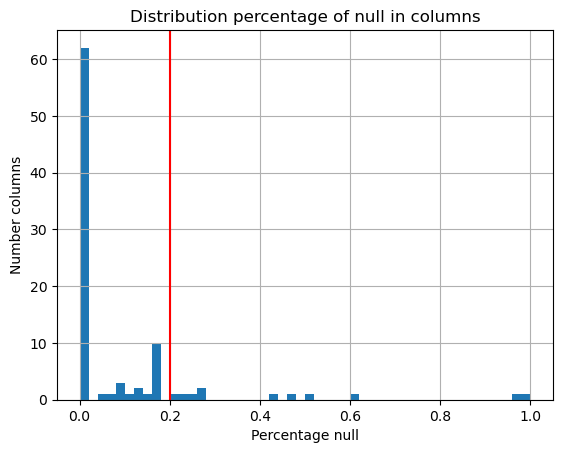

In [147]:
# Plot its distribution
seatle_null_cols.hist(bins=50)
plt.title('Distribution percentage of null in columns')
plt.xlabel('Percentage null')
plt.ylabel('Number columns')
plt.axvline(0.2, color='red');

In order to check if our threshold of dropping columns seems reasonable. A function has been create to see how many percentage of the data is kept using that threshold.

In [148]:
# Creating a function to see the effect of a chosen theshold removing columns 
# with percentage higher than the threshold
def cols_left_null_threshold_graph(df_null_rows):
    '''
    Creates a graphic to see how many rows are kept depending on a threshold.
    Rows with amount of nulls above the threshold will be removed,
    
    Args:
        df_null_rows: pandas dataframe - 2 columns, index and the percentage of nulls in that row
    
    returns: None
        Graphic showing the percentage of kept rows vs. threshold
    
    '''
    threshold = []
    rows_kept = []
    for i in np.arange(0, 1.05, 0.05):
        perc_rows_kept = (df_null_rows < i).sum() / df_null_rows.shape[0] * 100
        threshold.append(i)
        rows_kept.append(perc_rows_kept)

    plt.scatter(x=threshold, y=rows_kept)
    plt.title('Number of rows below threshold')
    plt.xlabel('Row discard threshold')
    plt.ylabel('Percentage of rows kept');
    
    pass

By using 0.2, we still keep 80% of our data, which seems a reasonable threshold. Increasing that threshold barely increase the number of usable features. 

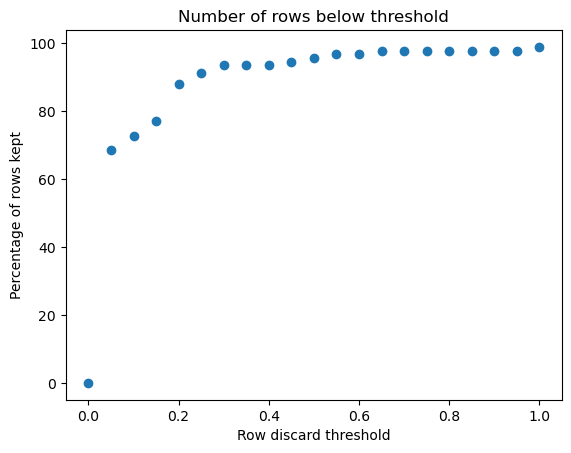

In [149]:
cols_left_null_threshold_graph(seatle_null_cols)

Create a list of columns to keep based on the threshold determined above.

In [150]:
# Create feature list to keep
col_to_keep = list(seatle_null_cols[seatle_null_cols < 0.2].index)

In [151]:
print('This leave us with {} features from {}'.format(len(col_to_keep), seatle_null_cols.shape[0]))

This leave us with 81 features from 92


In [152]:
seatle_listings_clean['host_response_time'].value_counts()

within an hour        1692
within a few hours     968
within a day           597
a few days or more      38
Name: host_response_time, dtype: int64

**After investigating manually the columns for the remaining features (not shown here).**
I tried to keep a mininum of features with regard to one “topic”. For example I kept the neighbourhood name but not the zip code or street name. The intention is to be able to build a model, trying to predict pricing, using both categorical features and numerical.
Comments beside each column kept, it explains why a column has been kept the required cleaning for each column that is kept and / or why a column has been removed (done by commenting the line).

In [153]:
model_col = [
#              'id',
#              'listing_url',
#              'scrape_id',
#              'last_scraped',
#              'name',
#              'summary',
#              'space',
#              'description',
#              'experiences_offered',
             'thumbnail_url', # needs encoding in yes / no
#              'medium_url',
#              'picture_url',
#              'xl_picture_url',
#              'host_id',
#              'host_url',
#              'host_name',
#              'host_since',
#              'host_location',
             'host_response_time', # categorical - needs one hot encoding
             'host_response_rate',
             'host_is_superhost', # needs encoding in yes / no
#              'host_thumbnail_url',
#              'host_picture_url',
#              'host_neighbourhood',
             'host_listings_count', 
             'host_total_listings_count',
#              'host_verifications', # methods of verifying host
             'host_has_profile_pic', # needs encoding in yes / no
             'host_identity_verified', # needs encoding in yes / no
#              'street',
#              'neighbourhood',
#              'neighbourhood_cleansed',
             'neighbourhood_group_cleansed', # categorical - needs one hot encoding gives the information on the neighbourhood 
#              'city', - Seatle / Boston 
#              'state', - 28 Values - used with 
#              'zipcode',
#              'market',
#              'smart_location',
#              'country_code',
#              'country',
#              'latitude',
#              'longitude',
             'is_location_exact', # needs encoding in yes / no
             'property_type', # categorical - needs one hot encoding
             'room_type', # categorical - needs one hot encoding
             'accommodates',
             'bathrooms',
             'bedrooms',
             'beds',
#              'bed_type', - too little variance
#              'amenities', # list of amentities
             'price', # Output variable
#              'guests_included', # Number of guest for the price
#              'extra_people', # Price of exta person, not interested
#              'minimum_nights',
#              'maximum_nights',
#              'calendar_updated', # not of intested
#              'has_availability', # always true
#              'availability_30',
#              'availability_60',
#              'availability_90',
#              'availability_365',
#              'calendar_last_scraped',
             'number_of_reviews',
#              'first_review', # correlated to host since
#              'last_review', # 
             'review_scores_rating',
             'review_scores_accuracy',
             'review_scores_cleanliness',
             'review_scores_checkin',
             'review_scores_communication',
             'review_scores_location',
             'review_scores_value',
#              'requires_license',
#              'jurisdiction_names', # only Washington
             'instant_bookable', # needs encoding in yes / no
             'cancellation_policy', # categorical - needs one hot encoding: flexible, moderate, strict
             'require_guest_profile_picture', # needs encoding in yes / no
             'require_guest_phone_verification', # needs encoding in yes / no
#              'calculated_host_listings_count',
             'reviews_per_month' # categorical - needs one hot encoding
            ]

Based on the comment above we have 3 type of feature encoding necessary:
- choice between 2 values: yes / no or "t" / "f": these will be encoded with 0 and 1
- value present / not present: for example "host_identity_verified". These will be encoded with 0 (not present) and 1 (present)
- categorical variable: for example "property_type". These will be encoded using the one hot encoding methode

These 3 methods are implemented in the two functions below:

In [154]:
def preprocess_encoding(df):
    ''' Preprocess and encodes choosen columns with 0 / 1
    
    Args:
        df: pandas Dataframe
        
    returns
        df_clean: pandas Dataframe with encoded columns
        
    '''
    # Changing true in 1 and false in 0
    df_clean = df.copy()
    col_true_false = ['host_is_superhost',
                      'is_location_exact',
                      'instant_bookable',
                      'require_guest_profile_picture',
                      'require_guest_phone_verification',
                      'host_has_profile_pic'
                     ]
    for col in col_true_false:
        df_clean[col] = df_clean[col].apply(lambda x: 1 if x == 't' else 0)
    
    # Encoding 1 if a value is present (for example url) and 0 if not (nan)
    col_one_hot_encode = ['thumbnail_url',
                          'host_identity_verified']
    for col in col_one_hot_encode:
        df_clean[col].fillna(0, inplace=True)
        df_clean[col] = df_clean[col].apply(lambda x: 0 if x == 0 else 1)
    
    # remove % in host_response_rate
    try:
        df_clean['host_response_rate'] = df_clean['host_response_rate'].str[:-1].astype('float64')
    except:
        print('host_response_rate already cleaned')
    
    return df_clean

def preprocess_encoding_cat_variables(df):
    ''' Preprocess and one hot encodes categorical variables
    
    Args:
        df: pandas Dataframe
        
    returns
        df_clean: pandas Dataframe with encoded columns
        
    '''
    # Define which columns needs encoding
    cols = ['property_type',
            'room_type',
            'cancellation_policy',
            'neighbourhood_group_cleansed',
            'host_response_time']

    df_clean = pd.get_dummies(df, columns=cols, dummy_na=True)
        
    return df_clean

In [155]:
# Select only the "model" columns and replaces "true / false" 
seatle_listings_model_clean = preprocess_encoding(seatle_listings_clean[model_col])

In [156]:
# Encodes the categorical variables
seatle_listings_model_clean = preprocess_encoding_cat_variables(seatle_listings_model_clean)

# Part 5: Evaluation

## 5.1 Question 1: Does pricing fluctuate over time? Can any patterns can be found?

### 5.1.0. Data preparation

In order to answer *Question 1* and *Question 2*, we need to aggregate *per day* 2 metrics:
- average price for a given date
- occupancy over all accomodating, being the percent of accomodation with guests on a given date

We create a function for that purpose and store the result in a common dataframe: df_daily_price.

In [157]:
def city_price_occupancy(df, city='Seatle'):
    '''
    Takes a calender dataframe and caculate average price and occupancy per day
    
    Args:
        df: pandas dataframe - 
        city: str - city name
    
    Returns:
        df: dataframe - date, avg price, occupancy (in %)
    '''
    # caculate number oder listing_id in the dataframe
    n_listing_id = df['listing_id'].nunique()
    # calculte occupancy per day
    df_occupancy = df[df['available'] == 't'].groupby(['date'])['listing_id'].agg([('occupancy', 'count')]) / n_listing_id
    
    # calculate the mean price per day
    df_mean_day_price = df.groupby('date')['price'].mean().reset_index()
    
    # Add city name
    df_mean_day_price['city'] = city
    
    # Joins occupancy and price for a date
    df_day = df_mean_day_price.join(df_occupancy, on=['date'], how='left')
    
    return df_day

In [158]:
# Calculate occupancy per day for Seatle
seatle_mean_day_price = city_price_occupancy(seatle_calendar_clean, city='Seatle')

In [159]:
# Calculate occupancy per day for Boston
boston_mean_day_price = city_price_occupancy(boston_calendar_clean, city='Boston')

In [160]:
# Concatenate both cities in one dataset, allowing us to compare both in one visualisation
df_daily_price = pd.concat([boston_mean_day_price, seatle_mean_day_price], ignore_index=True)

### 5.1.1: Analysis

We will notice a high frequency fluctuation of pricing in the visualisation below. We decide to add the weekday name to the dataframe in order to verify that hypothesis. 

In [161]:
df_daily_price['weekday'] = pd.to_datetime(df_daily_price['date'], format='%m/%d/%y').dt.weekday
df_daily_price['day_name'] = pd.to_datetime(df_daily_price['date'], format='%m/%d/%y').dt.day_name()

### 5.1.2: Visualisation

Evolution of the average price over time

In [162]:
fig = px.line(df_daily_price, x='date', y='price', color='city',
              labels={
                     "date": "date of stay",
                     "price": "average price ($)",
                     "city": "city"
                 },
                title="Average price of a night stay")
fig.show()

__Observations from time series below__
- On this time series it is obvious that a direct comparison between the 2 cities is only possible on a short timeframe (Sep 2016 - Dec 2016).
- High frequency price variation is observed, which suggest a dependency on weekday worth investigating.
- Pricing in Boston between september 2016 and January seems unusually high compared the 2017.

We decide to investigate the influence of the **day of the week**, looking at the price distribution for each weekday. We use a boxplot for that purpose.

In [163]:
fig = px.box(df_daily_price, x='day_name', y='price', color='city',
             labels={
                     "day_name": "weekday",
                     "price": "price ($)",
                     "city": "city"
                     },
             title="Distribution of price on weekday")
fig.show()

**Observation**: Unsurprisingly are Friday an Saturday the most expensive nights on average

### 5.1.3: Conclusion
- Friday and Saturdays are the most expensive nights.
- A seasonal effect could be guessed but not verify, due to lack of data over several years

## 5.2 Question 2: Does occupancy of accomodations fluctuate over time? Can any patterns can be found?


### 5.2.1: Analysis / Visualisation

We start to investigate how occupancy varies over time and if the weekday pattern, can be found.

In [164]:
fig = px.line(df_daily_price, x='date', y='price', color='city')
fig = px.line(df_daily_price, x='date', y='occupancy', color='city',
              labels={
                     "date": "date",
                     "occupancy": "occupancy (%)",
                     "city": "city"
                     },
             title="Evaluation of occupancy over time")
fig.show()

We notice for both cities that the start of the time series shows a gradual increase of occupancy (maybe due to a launch phase of the service?). This generates a bias in our scatter plot (see below between price and occupancy) and can lead to a misinterpretation suggesting lower occupancy leads to higher prices.

We decide to investigate the relationship between pricing and occupancy on a given day using a scatterplot.

In [165]:
fig = px.scatter(df_daily_price, x='occupancy', y='price', color='city')
fig.show()

Points of low occupancy match with the starting phase (occupancy < 0.6 for Seatle and < 0.4 for Boston). No clear relationship can be seen in this scatterplot.

### 5.2.2: Conclusion

No clear relationship could be found between occupancy and average price.

## 5.3 Question 3: Are there any features that correlates with pricing of accommodation?

### 5.3.1. Analysis

We start this analysis by looking into correlations between pricing and other numerical features. We use the listing dataframe for this analysis. We will be investigating non numerical features in the section 5.4.

This function will help us to view the most correlated features to the price column, sorting them by Pearson coefficent.

In [166]:
def calculate_correlations(df, input_col='price', city='Seatle'):
    ''' Calculate a correlation matrix based on price
        Args:
            df: pandas Dataframe - listing dataframe
            city: str - name of city
        returns
            df_coef: pandas Dataframe
        
        df_coef is a Dataframe with Pearson correlation coefficients
        ouptut sorted by coefficient
        Removed are nan and autocorrelation of input_col 
    '''
    # Calculating correlation coefficient
    df_corr = df.corr()
    # Sorting values and rename index to feature
    df_coef = df_corr[input_col].sort_values(ascending=True).reset_index().rename(columns={'index': 'feature'})
    
    # Removing empty correlations
    df_coef = df_coef[~df_coef[input_col].isnull()]
    # Add city name
    df_coef['city'] = city
    # Remove autocorrelation input_col - input_col
    df_coef = df_coef[~(df_coef['feature'] == input_col)]
    
    return df_coef

In [167]:
# Calculate correlation coefficient with price
seatle_coef = calculate_correlations(seatle_listings_clean, city='Seatle')
boston_coef = calculate_correlations(boston_listings_clean, city='Boston')

# Combine both dataset into one
city_corr = pd.concat([seatle_coef, boston_coef])

### 5.3.2. Visualisation

We first have a look at **all correlation coefficient** before focussing on the correlation to pricing. For this quick check, we only use the seatle data.

In [168]:
# Display correlation coefficient for Seatle
fig = px.imshow(seatle_listings_clean.corr())
fig.update_xaxes(dtick=1)
fig.update_yaxes(dtick=1)
plt.figure(figsize=(50, 50))
fig.show()

<Figure size 5000x5000 with 0 Axes>

We see 3 “blocks” of higher correlation which matches our intuition:
- related to the accommodation (number of bedrooms, beds, square feet, etc.)
- related to availability (30, 60, 90 days)
- related to reviews (overall, cleanliness, location, etc.)

Further we look only at the correlation of price for each city. We decided to put them side by side, to be able to assess if both city show similar results. 

In [169]:
fig = px.bar(city_corr, y='feature', x='price', orientation='h', color='city', barmode='group',
            labels={
                     "feature": "feature",
                     "price": "Pearson correlation coefficient with price",
                     "city": "city"
                     },
             title="Correlation of features with price")
fig.update_yaxes(dtick=1)
plt.figure(figsize=(10, 50))
fig.show()

<Figure size 1000x5000 with 0 Axes>

**Observations**:
- The price is most correlated to features associated with the size of the accomodation and the number of guests it can accomodate.
- From the reviews scores, the most important one is the location of the property and cleanliness.
- Interestlingly the number of reviews and reviews per month are negatively correlated to price.

The negative correlation of the number of reviews and reviews per month seem counter intuitive. To investigate it further, we decide to bucket and display a boxplot.

In [170]:
seatle_listings_clean['reviews_per_month_grouped'] = np.round(seatle_listings_clean['reviews_per_month']/0.5)*0.5

In [171]:
fig = px.box(seatle_listings_clean, x='reviews_per_month_grouped', y='price')
fig.show()

The datapoints with low number of reviews per month (< 1) are showing a higher price, explaining the negative correlation. We also notice a higher number of outliers and higher spread. We suspect that the number of accomodation with low number of review per month is high. To confirm this, we add visualise its  distribution.

<AxesSubplot:>

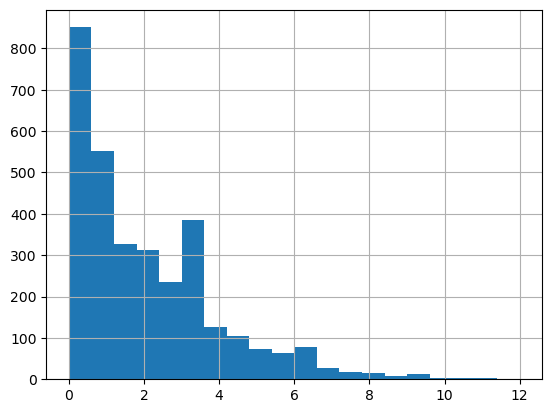

In [172]:
# Distribution of number of review in the seatle dataset
seatle_listings_clean['reviews_per_month_grouped'].hist(bins=20)

As expected the number of accomodations with low number of reviews per month is high.

We will repeat the same method for the **number of reviews**, creating buckets of 10 and visualising the boxplot.

In [173]:
# Grouping number_of_reviews for creating box plot
seatle_listings_clean['number_of_reviews_grouped'] = np.round(seatle_listings_clean['number_of_reviews']/10)*10

In [174]:
fig = px.box(seatle_listings_clean, x='number_of_reviews_grouped', y='price')
# fig = px.violin(df_daily_price, x='day_name', y='price', color='city')
fig.show()

Also here we see the same behaviour. The negative price correlation is due to the high amount of accomodation with few reviews.

### 5.3.3 Conclusion

We see that the most correlated features are similar between the two cities. These are related to:
- accomodation itself and mainly its size (square feet, number of rooms, number of guest that can stay).
- host listing: number of accommodations offered by the same host.
- reviews: location and overall score seem to be the most important.

## 5.4. Question 3b: Are they categorical features correlating with the price ?

### 5.4.1. Analysis

We use the same method and function that in section 5.3 to create a dataframe with price correlation. The difference to section 5.3 being that we have not only numerical features and use our manual selection from section 4

In [175]:
# Calculate new correlation with the added dummy features
s_corr = calculate_correlations(seatle_listings_model_clean)

### 5.4.2. Visualisation

Similar to the section 5.3, we show the correlation coefficient related to price. For readability reason, I decided to only keep coefficient with absolute value higher than 0.1.

In [176]:
fig = px.bar(s_corr[np.abs(s_corr['price']) > 0.1].sort_values(by='price', ascending=True), y='feature', x='price', orientation='h', barmode='group',
            labels={
                     "feature": "feature",
                     "price": "Pearson correlation coefficient with price",
                     },
             title="Correlation of features with price")
fig.update_yaxes(dtick=1)
plt.figure(figsize=(10, 50))
fig.show()

<Figure size 1000x5000 with 0 Axes>

## 5.4.3 Conclusion

We notice that additionally to the accomation size related features from section 5.3, new features are correlated to pricing:

- **room type** “Entire home or appartment” leads to higher price whereas a shared room or private room to cheaper price.
- **neighbourhood**: slightly higher price is except for “downtown”.
- **cancellation policy**: Interestingly the strict policy is correlates positively vs. flexible is negatively. This is probably related to the type of accomodation offered and would need to be investigated further.

## Backup to be deleted

In [169]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [170]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [159]:
y = seatle_listings_model_clean['price']
X = seatle_listings_model_clean.drop('price', axis=1)

In [209]:
y_rounded = np.round(y/10)* 10

In [160]:
seatle_listings_model_imputed = pd.DataFrame(imputer.fit_transform(X))
seatle_listings_model_scaled = scaler.fit_transform(seatle_listings_model_imputed)

In [172]:
X_scaled = seatle_listings_model_scaled

In [210]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_rounded, test_size=0.3, random_state=42)

In [177]:
from sklearn.ensemble import RandomForestClassifier

In [213]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=0)

In [214]:
score = clf.score(X_test, y_test)

In [215]:
score

0.20680628272251309

In [216]:
# Apply PCA to the data
pca = PCA()
X_seatle_pca = pca.fit_transform(X_scaled)

In [198]:
pca.explained_variance_ratio_

array([6.43267853e-02, 5.56421073e-02, 4.55939750e-02, 3.85126295e-02,
       3.20008059e-02, 2.77134583e-02, 2.34567968e-02, 2.23526043e-02,
       2.10912381e-02, 2.06032248e-02, 1.90342562e-02, 1.88803308e-02,
       1.79816047e-02, 1.73520213e-02, 1.72615402e-02, 1.71731769e-02,
       1.70047225e-02, 1.67385870e-02, 1.64692738e-02, 1.59216865e-02,
       1.57981036e-02, 1.56612966e-02, 1.55471265e-02, 1.53005626e-02,
       1.49872377e-02, 1.48441040e-02, 1.47497396e-02, 1.46372998e-02,
       1.45923687e-02, 1.45276882e-02, 1.43948951e-02, 1.43484126e-02,
       1.42397067e-02, 1.41866231e-02, 1.40875127e-02, 1.37378076e-02,
       1.36918917e-02, 1.35477867e-02, 1.32266330e-02, 1.29843715e-02,
       1.27744922e-02, 1.24288540e-02, 1.23341441e-02, 1.20698215e-02,
       1.17960644e-02, 1.12647505e-02, 1.10539031e-02, 1.08401814e-02,
       1.01270069e-02, 9.66432500e-03, 8.57096022e-03, 7.92280611e-03,
       7.10230877e-03, 6.55568653e-03, 6.19013474e-03, 6.07429801e-03,
      

In [226]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_seatle_pca, y, test_size=0.3, random_state=42)
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_seatle_pca, y_rounded, test_size=0.3, random_state=42)

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [221]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_pca,y_train_pca)

y_train_hat =logisticRegr.predict(X_train_pca)
train_accuracy = accuracy_score(y_train_pca, y_train_hat)*100
print('"Accuracy for our Training dataset with PCA is: %.4f %%' % train_accuracy)

"Accuracy for our Training dataset with PCA is: 33.6826 %


C:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [222]:
from sklearn.linear_model import LinearRegression

In [227]:
reg = LinearRegression().fit(X_train_pca, y_train_pca)
reg.score(X_train_pca, y_train_pca)

0.5884426966655669

In [228]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.5877789899110089

In [229]:
import statsmodels.api as sm

In [232]:
#fit linear regression model
lin_model = sm.OLS(y, X_scaled).fit()

# Display model performance
print(lin_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.198
Model:                            OLS   Adj. R-squared (uncentered):              0.184
Method:                 Least Squares   F-statistic:                              14.47
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                   1.40e-134
Time:                        10:19:20   Log-Likelihood:                         -24291.
No. Observations:                3818   AIC:                                  4.871e+04
Df Residuals:                    3754   BIC:                                  4.911e+04
Df Model:                          64                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [243]:
X.columns[70:73]

Index(['host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_response_time_nan'],
      dtype='object')